# 1. Attention Based Topics (ABT)

In [1]:
!pip install wordcloud
!pip install -U sentence-transformers
!pip install gensim

In [2]:
from wordcloud import WordCloud

class Topic:
    def __init__(self, cluster):
        self.cluster = cluster
        self.sentences = []
        self.sentences_dump = ""
        self.words = []
        self.wordcloud = WordCloud()
        self.texts = []
        self.sorted_terms = []
        self.sorted_tfidf = []
        self.coherence = 0.0
        
class TopicModel:
    def __init__(self):
        self.sentences = []
        self.vocabulary = []     
        self.topics = []
        self.topics_coherence = 0.0
        
model = TopicModel()

## Step 1: Sentences Modeling

In [3]:
import os.path

DATASET = 'clicr'
DATASET_PATH = '../datasets/'+DATASET+'/cases-titles.txt'

BERT_MODEL = 'fagner/envoy'

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += BERT_MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
from sentence_transformers import SentenceTransformer

with open(DATASET_PATH) as f:
    model.sentences = f.readlines()
language_model = SentenceTransformer(BERT_MODEL)
embeddings = language_model.encode(model.sentences)

# In order to use locally stored Language Models
# MODEL_PATH = '../../models/' + BERT_MODEL
# language_model = SentenceTransformer(MODEL_PATH)
# embeddings = language_model.encode(model.sentences)

No sentence-transformers model found with name /home/jovyan/.cache/torch/sentence_transformers/fagner_envoy. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/jovyan/.cache/torch/sentence_transformers/fagner_envoy were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/.cache/torch/sentence_transformers/fagner_envoy and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bia

<Figure size 640x480 with 0 Axes>

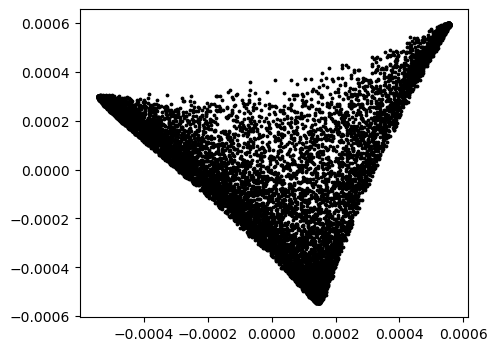

In [5]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(embeddings)
 
x = X_2d[:,0]
y = X_2d[:,1]

plt.clf()
plt.figure(figsize=(5, 4))
plt.scatter(x, y, color='black', s=3)
plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(BERT_MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')

## Step 2: Sentences Aggregation

In [6]:
DISTANCE_THRESHOLD = 250

In [7]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(linkage='ward', distance_threshold=DISTANCE_THRESHOLD, n_clusters=None)
clustering_model = clustering_model.fit(embeddings)
n_clusters = clustering_model.n_clusters_

print('Distance Threshold: ', DISTANCE_THRESHOLD)
print('Resulting Clusters:',  n_clusters)

Distance Threshold:  250
Resulting Clusters: 4


<Figure size 640x480 with 0 Axes>

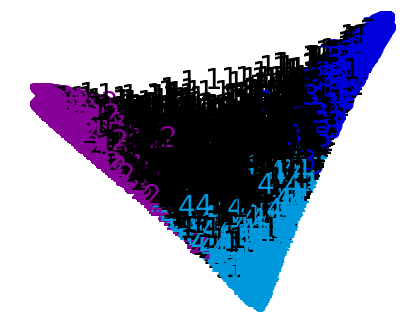

In [8]:
plt.clf()
# plt.figure(figsize=(10, 8))
plt.figure(figsize=(5, 4))
# plt.figure(figsize=(1.5, 1))

plt.scatter(x, y, color='w', s=1)

for i, sentence in enumerate(model.sentences):
    # plt.scatter(x[i], y[i], color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), s=0.5)
    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=3)
    plt.annotate(clustering_model.labels_[i]+1, (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=20)

    
if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

plt.axis("off")
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(BERT_MODEL).replace('/','').replace('.','') + '.png', bbox_inches='tight', transparent=True)
# plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(BERT_MODEL).replace('/','').replace('.','') + '.jpg', bbox_inches='tight', transparent=True)
# plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(BERT_MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')

In [9]:
# plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(BERT_MODEL).replace('/','').replace('.','') + '.jpg', bbox_inches='tight', transparent=True)


### Topics Hierarchy

<Figure size 640x480 with 0 Axes>

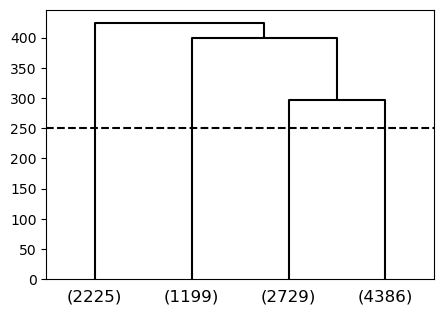

In [10]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.clf()
# plt.figure(figsize=(7,5))
plt.figure(figsize=(5,3.5))

counts = np.zeros(clustering_model.children_.shape[0])
n_samples = len(clustering_model.labels_)

for i, merge in enumerate(clustering_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else: current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering_model.children_, clustering_model.distances_, counts]).astype(float)


# r = dendrogram(linkage_matrix, truncate_mode=None, above_threshold_color='black', color_threshold=0, no_labels=True)
r = dendrogram(linkage_matrix, truncate_mode='lastp', p=n_clusters, color_threshold=0, above_threshold_color='black')

plt.axhline(c='black', linestyle='--', y=DISTANCE_THRESHOLD) 

plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(BERT_MODEL).replace('/','').replace('.','')+str(n_clusters)+'clusters.png', bbox_inches='tight')
# plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(BERT_MODEL).replace('/','').replace('.','')+str(n_clusters)+'clusters.eps', bbox_inches='tight')

## Step 3: Representing Topics

In [11]:
MAX_DF = 1
TOP_WORDS = 10

In [12]:
# for t in model.topics:
#     print(len(t.sentences))
#     # print(t.sentences_dump)

In [13]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

model.topics = [Topic(i) for i in range(n_clusters)]
for i in range(len(model.sentences)):
    cluster_index = clustering_model.labels_[i]
    model.topics[cluster_index].sentences.append(model.sentences[i])
    model.topics[cluster_index].sentences_dump += model.sentences[i] + " "

tfidf_model = TfidfVectorizer(stop_words=['of', 'in', 'with', 'the', 'and', 'an', 'to'], max_df=MAX_DF,smooth_idf=True)


c_tfidf = tfidf_model.fit_transform([topic.sentences_dump for topic in model.topics])
tfidf_matrix = c_tfidf.toarray()

terms = tfidf_model.get_feature_names_out()
model.vocabulary = terms

terms_by_topic = tfidf_model.inverse_transform(c_tfidf)
        
for i, topic in enumerate(model.topics):
    sorted_term_indexes = np.argsort(-1*tfidf_matrix[topic.cluster])
    topic.sorted_terms = [terms[j] for j in sorted_term_indexes]   
    topic.sorted_tfidf = [tfidf_matrix[topic.cluster][j] for j in sorted_term_indexes]   

    
    topic.words = terms_by_topic[i]
    
    dense = c_tfidf[topic.cluster].todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

    topic.wordcloud = WordCloud(mode='RGBA', background_color="white", max_words=TOP_WORDS, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))

In [14]:
for t in model.topics:
    print('Topic ',t.cluster)
    print(t.sorted_terms[:10])
    print(t.sorted_tfidf[:10])

    print(t.sorted_terms[-2])
    print(t.sorted_tfidf[-2])
    # print(len(t.sorted_terms))
    print('---------------')


Topic  0
['osteogenesis', 'puncture', 'epigastric', 'leishmaniasis', 'strongyloides', 'gallstones', 'panniculitis', 'paroxysmal', 'hydronephrosis', 'cavitary']
[0.11352372405926854, 0.11352372405926854, 0.09933325855185995, 0.0851427930444514, 0.0851427930444514, 0.0851427930444514, 0.0851427930444514, 0.0851427930444514, 0.07095232753704284, 0.07095232753704284]
hemisphere
0.0
---------------
Topic  1
['thrombocytopenic', 'nephrotic', 'statin', 'thiamine', 'valproate', 'mephedrone', 'cannabis', 'nitrofurantoin', 'neutropenia', 'myxoedema']
[0.2530454820936417, 0.15815342630852608, 0.15815342630852608, 0.14233808367767345, 0.12652274104682085, 0.12652274104682085, 0.11070739841596823, 0.11070739841596823, 0.11070739841596823, 0.11070739841596823]
globules
0.0
---------------
Topic  2
['mucinous', 'adenoid', 'liposarcoma', 'spindle', 'mucosa', 'invasion', 'desmoplastic', 'metaplasia', 'mucoepidermoid', 'papilloma']
[0.30709613431999755, 0.2598505751938441, 0.2126050160676906, 0.21260501

<Figure size 640x480 with 0 Axes>

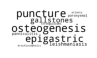

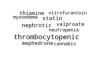

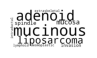

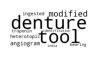

In [15]:
from matplotlib import pyplot as plt 

plt.clf()

for topic in model.topics:
    plt.figure(figsize=(1, 1))
    # plt.figure(figsize=(1.5, 1.5))
    # plt.figure(figsize=(2.5, 2.5))
    
    plt.imshow(topic.wordcloud)
    plt.axis("off")

    if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')
    plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/wordcloud'+str(topic.cluster)+'.png', transparent=True, bbox_inches='tight')
    # plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/wordcloud'+str(topic.cluster)+'.jpg', transparent=True, bbox_inches='tight')

# 2. Validation

In [16]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(t) for t in terms_by_topic]
texts = [[dictionary[word_id] for word_id, freq in c] for c in corpus]

cm = CoherenceModel(topics=[topic.words for topic in model.topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

model.topics_coherence = cm.get_coherence()
model.coherence_per_topic = cm.get_coherence_per_topic()

for i, coherence in enumerate(model.coherence_per_topic):
    model.topics[i].coherence = coherence

print('Total coherence: ', model.topics_coherence)
print('Coherence by topic: ', model.coherence_per_topic)    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [17]:


### corrigir ordem dos termos. Ja esta corrigido no notebook oficial e no artigo
print('Topics in ascending sort of coherence.')
sorted_topic_indexes = np.argsort(model.coherence_per_topic)
for i,j in enumerate(sorted_topic_indexes):    
    print(i, model.topics[j].coherence, model.topics[j].sorted_terms[:10])



Topics in ascending sort of coherence.
0 0.4526863182120029 ['mucinous', 'adenoid', 'liposarcoma', 'spindle', 'mucosa', 'invasion', 'desmoplastic', 'metaplasia', 'mucoepidermoid', 'papilloma']
1 0.4704440484770179 ['thrombocytopenic', 'nephrotic', 'statin', 'thiamine', 'valproate', 'mephedrone', 'cannabis', 'nitrofurantoin', 'neutropenia', 'myxoedema']
2 0.6427582875727739 ['osteogenesis', 'puncture', 'epigastric', 'leishmaniasis', 'strongyloides', 'gallstones', 'panniculitis', 'paroxysmal', 'hydronephrosis', 'cavitary']
3 0.6490238562040449 ['tool', 'denture', 'modified', 'angiogram', 'ingested', 'heterotopic', 'troponin', 'bearing', 'wire', 'identification']


In [18]:
with open(OUTPUT_PATH + '/topic-attention-results.txt', "a") as file:
    print('Hyper-parameters: ', file=file) 
    print('Language Model: ' + BERT_MODEL + '\t Distance Threshold: '+str(DISTANCE_THRESHOLD) + '\t Resulting Topics: '+str(n_clusters) + '\t TfIdf Threshold: '+str(MAX_DF) + '\t Top Words: '+str(TOP_WORDS), file=file)   
    print("", file=file)
    for topic in model.topics:
        print('Topic '+str(topic.cluster), file=file)    
        print('Documents length: '+str(len(topic.sentences)), file=file)
        print('Terms length: '+str(len(topic.words)), file=file)

        print('Coherence: '+str(topic.coherence), file=file)
        print('Top Words: '+str(topic.sorted_terms[:10]), file=file)  
        
        print('Document samples: '+str(topic.sentences[:2]), file=file)  

        
        print('', file=file)

    print('Total Coherence: '+str(model.topics_coherence), file=file)  
    print('Total Terms considered: '+str(len(model.vocabulary)), file=file)
    print('----------------------------------------------------------------------------', file=file)  

In [19]:
# # topics[0].sorted_terms[:10]
# for t in model.topics:
#     print(t.sorted_terms[:10])
#     print(t.sorted_tfidfs[:10])
#     print('\n\n')

#     print(len(t.terms))
#     print(len(t.sorted_terms))
#     print(len(t.sorted_tfidfs))
#     print()


#     # sorted_terms[:10]

